## **Initiation**

Install PyDrive and import related packages

In [0]:
#Please run this first
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#import modules

import numpy as np
import pandas as pd
# from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
import sklearn 

import scipy.stats as spst
from sklearn.utils import shuffle
from sklearn import metrics

#imbalanced-learn module
import imblearn

## **Data Loading**

Load three datasets

In [3]:
link="https://drive.google.com/open?id=1Eh9gP22ylXjRzxpnWInFhsM80XcDUjO7"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('online_shoppers_intention.csv')
shoppers = pd.read_csv('online_shoppers_intention.csv')
shoppers.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
#Check If there is any Invalid Data

#Data Clean: if Administrative = 0,	Administrative_Duration	should be 0
filter1 = (shoppers['Administrative'] == 0) & (shoppers['Administrative_Duration'] != 0) 
print(shoppers[filter1].size)
#Same for Informational 
filter2 = (shoppers['Informational'] == 0) & (shoppers['Informational_Duration'] != 0) 
print(shoppers[filter2].size)
#Same for ProductRelated
filter3 = (shoppers['ProductRelated'] == 0) & (shoppers['ProductRelated_Duration'] != 0) 
print(shoppers[filter3].size)

0
0
0


In [5]:
#check null in each column
shoppers.isna().sum(axis = 0)


Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
shoppers.shape

(12330, 18)

In [7]:
shoppers.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

## **Basic Insights**


**Audience**

---



In [8]:
shoppers['VisitorType'].value_counts()


Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

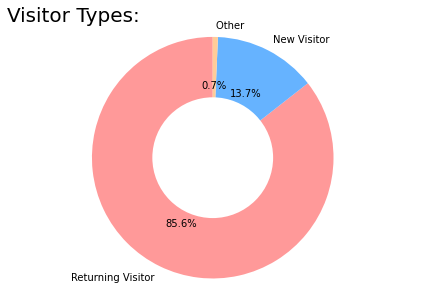

In [9]:
# Pie chart
labels = ['Returning Visitor', 'New Visitor ', 'Other ']
sizes = [10551, 1694, 85]
#colors
colors = ['#ff9999','#66b3ff','#ffcc99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Visitor Types:',fontsize = 20,loc='left')
plt.show()

**Month**

---



In [10]:
shoppers['Month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

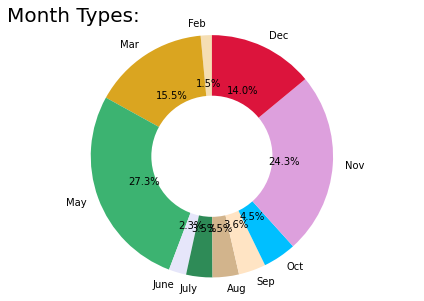

In [11]:
labels = ['Feb','Mar','May','June','July','Aug','Sep','Oct','Nov','Dec']
sizes = [184,1907,3364,288,432,433,448,549,2998,1727]
#colors
colors = ['wheat','goldenrod','mediumseagreen','lavender','seagreen',
          'tan','bisque','deepskyblue','plum','crimson']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Month Types:',fontsize = 20,loc='left')
plt.show()

In [12]:
shoppers.groupby('SpecialDay').mean()[['Revenue']]

,Revenue
SpecialDay,
0.0,0.165268
0.2,0.078652
0.4,0.053498
0.6,0.082621
0.8,0.033846
1.0,0.064935


In [13]:
shoppers.groupby('Month').mean()[['Revenue']]

,Revenue
Month,
Aug,0.175520
Dec,0.125072
Feb,0.016304
Jul,0.152778
June,0.100694
Mar,0.100682
May,0.108502
Nov,0.253502
Oct,0.209472


In [14]:
shoppers.groupby('Region').mean()[['Revenue']]

,Revenue
Region,
1,0.161297
2,0.165493
3,0.145235
4,0.148054
5,0.163522
6,0.139130
7,0.156373
8,0.129032
9,0.168297


In [15]:
shoppers.groupby('Weekend').mean()[['Revenue']]

,Revenue
Weekend,
False,0.148911
True,0.173989


In [16]:
shoppers.groupby('VisitorType').mean()[['Revenue']]

,Revenue
VisitorType,
New_Visitor,0.249115
Other,0.188235
Returning_Visitor,0.139323


# **Data Clean Before Prediction**

The percentage of ending with transactions case only count for 15.474452554744525 %
False    10422
True      1908
Name: Revenue, dtype: int64


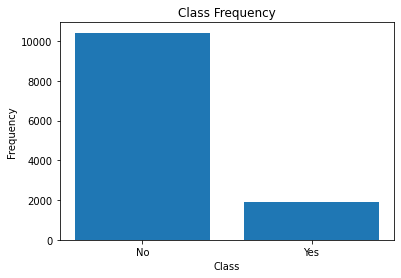

In [17]:

#imbalanced dataset
classes = shoppers['Revenue'].values * 1
unique, counts = np.unique(classes, return_counts=True)

prob_revenue = 1908/len(shoppers)
print("The percentage of ending with transactions case only count for",prob_revenue*100,"%")

print(shoppers['Revenue'].value_counts())

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.xticks([0,1],labels=('No','Yes'))
plt.ylabel('Frequency')
plt.show()

# **Split Data**

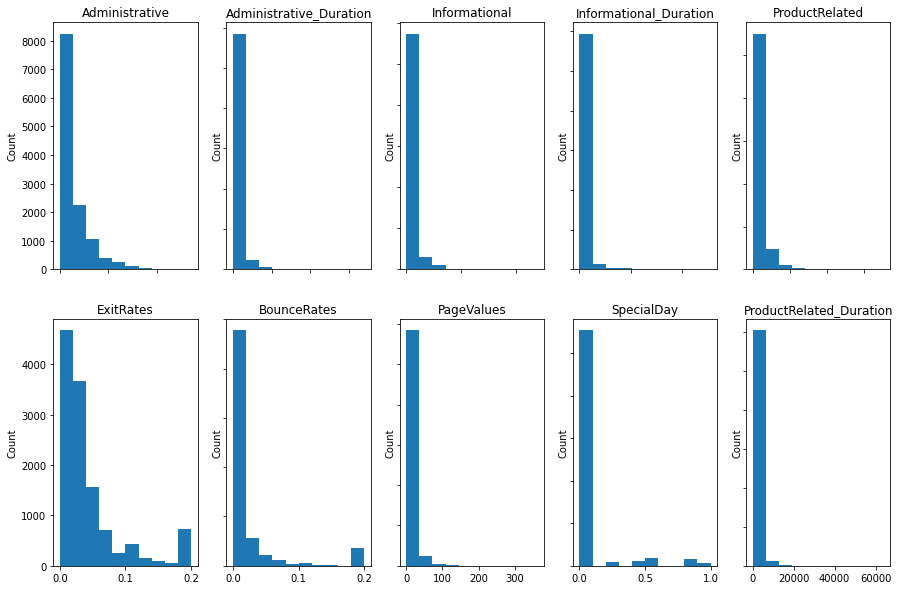

In [18]:
#skewed data?
fig, axs = plt.subplots(2, 5,figsize=(15,10))

axs[0, 0].hist(shoppers['Administrative'].values)
axs[0, 0].set_title('Administrative')

axs[0, 1].hist(shoppers['Administrative_Duration'].values)
axs[0, 1].set_title('Administrative_Duration')

axs[0, 2].hist(shoppers['Informational'].values)
axs[0, 2].set_title('Informational')

axs[0, 3].hist(shoppers['Informational_Duration'].values)
axs[0, 3].set_title('Informational_Duration')

axs[0, 4].hist(shoppers[ 'ProductRelated'].values)
axs[0, 4].set_title( 'ProductRelated')

axs[1, 0].hist(shoppers[ 'ExitRates'].values)
axs[1, 0].set_title('ExitRates')


axs[1, 1].hist(shoppers['BounceRates'].values)
axs[1, 1].set_title('BounceRates')


axs[1, 2].hist(shoppers[ 'PageValues'].values)
axs[1, 2].set_title('PageValues')

axs[1, 3].hist(shoppers['SpecialDay'].values)
axs[1, 3].set_title('SpecialDay')

axs[1, 4].hist(shoppers[ 'ProductRelated_Duration'].values)
axs[1, 4].set_title('ProductRelated_Duration')

for ax in fig.get_axes():
    ax.label_outer()
for ax in axs.flat:
    ax.set_ylabel("Count")


In [0]:
shoppers=shoppers.rename(columns={"Administrative_Duration":"AdminDuration","Informational_Duration":"InforDuration","ProductRelated_Duration":"ProductDuration"})

In [0]:
shoppers = shoppers.assign(revenue = shoppers['Revenue']*1)
shoppers = shoppers.drop(columns = {'Revenue'})


In [21]:
#Cross Validation
shoppers = shuffle(shoppers)
# Training set: 80%
train = shoppers[0:int(0.80*shoppers.shape[0])]
# Validation set: 10%
valid = shoppers[int(0.80*shoppers.shape[0]):int(0.90*shoppers.shape[0])]
# Testing set: 10%
test = shoppers[int(0.90*shoppers.shape[0]):]

print("Train set:",train.shape[0] )
print("Valid set:",valid.shape[0] )
print("Test set:", test.shape[0] )

Train set: 9864
Valid set: 1233
Test set: 1233


In [22]:
train.head(4)

,Administrative,AdminDuration,Informational,InforDuration,ProductRelated,ProductDuration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,revenue
11736,2,51.0,3,68.75,227,12460.67006,0.007569,0.014820,0.000000,0.0,Nov,2,2,1,2,Returning_Visitor,False,0
10532,0,0.0,0,0.00,24,783.37500,0.000000,0.004167,15.756363,0.0,Nov,1,1,4,3,Returning_Visitor,False,1
5906,1,5.5,3,169.20,14,517.66000,0.011111,0.022222,50.183139,0.0,Jul,3,2,1,2,Returning_Visitor,True,0
1012,0,0.0,0,0.00,2,92.00000,0.000000,0.100000,0.000000,0.0,Mar,2,2,8,1,Returning_Visitor,False,0


In [0]:
def confusion_metric(y_test, y_pred):
  from sklearn.metrics import confusion_matrix
  import seaborn as sns
  cm = confusion_matrix(y_test,y_pred)
  class_names=['No Revenue','Revenue'] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Set3" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

# **Logistic Regressions**

####Lasso Logistic Regression

---



In [32]:
# Lasso Logistic Regression
candidate_formula = "revenue~ProductRelated+Administrative+AdminDuration\
                     +Informational+InforDuration+ProductDuration\
                      +BounceRates+ExitRates+PageValues+SpecialDay+C(Month)\
                     +C(OperatingSystems)+C(Browser)+C(Region)+C(TrafficType)+C(VisitorType)+C(Weekend)"
model1 = logit(formula = candidate_formula,data = train).fit_regularized(alpha=0, L1_wt=1)


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2903408057483724
            Iterations: 451
            Function evaluations: 472
            Gradient evaluations: 451


In [34]:
print("AUC train:",metrics.accuracy_score(train["revenue"],model1.predict(train)>0.5))
print("AUC valid:",metrics.accuracy_score(valid["revenue"],model1.predict(valid)>0.5))
#print("AUC test:",metrics.accuracy_score(test["revenue"],model1.predict(test)>0.5))

AUC train: 0.8854420113544201
AUC valid: 0.8864557988645579


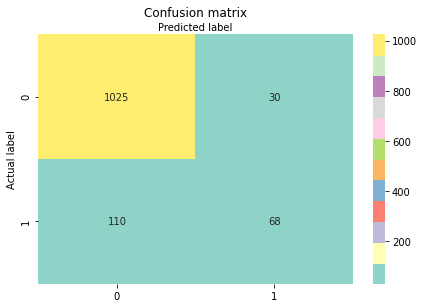

In [35]:
confusion_metric(valid["revenue"].values,model1.predict(valid)>0.5)

####Lasso Logistic Regression with Undersampling

---



In [36]:
from sklearn.utils import resample

train_revenue = train[train['revenue']==1]
train_norevenue = train[train['revenue']==0]

train_norevenue_under = train_norevenue.sample(len(train_revenue),replace = False)
train_under = pd.concat([train_revenue, train_norevenue_under], axis=0)

candidate_formula = "revenue~ProductRelated+Administrative+AdminDuration\
                     +Informational+InforDuration+ProductDuration\
                      +BounceRates+ExitRates+PageValues+SpecialDay+C(Month)\
                     +C(OperatingSystems)+C(Browser)+C(Region)+C(TrafficType)+C(VisitorType)+C(Weekend)"
model2 = logit(formula = candidate_formula,data = train_under).fit_regularized(alpha=0, L1_wt=1)


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4110802336956482
            Iterations: 515
            Function evaluations: 537
            Gradient evaluations: 515


In [37]:
print("AUC train:",metrics.accuracy_score(train_under["revenue"],model2.predict(train_under)>0.5))
print("AUC valid:",metrics.accuracy_score(valid["revenue"],model2.predict(valid)>0.5))
#print("AUC test:",metrics.accuracy_score(test["revenue"],model2.predict(test)>0.5))

AUC train: 0.8267487046632125
AUC valid: 0.8256285482562855


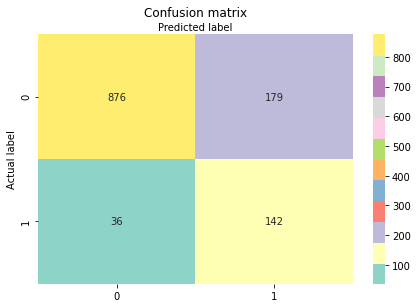

In [38]:
confusion_metric(valid["revenue"].values,model2.predict(valid)>0.5)

####Lasso Logistic Regression with Oversampling

---

In [39]:
from sklearn.utils import resample

train_revenue_over = train_revenue.sample(len(train_norevenue),replace = True)
train_over = pd.concat([train_norevenue, train_revenue_over], axis=0)

candidate_formula = "revenue~ProductRelated+Administrative+AdminDuration\
                     +Informational+InforDuration+ProductDuration\
                      +BounceRates+ExitRates+PageValues+SpecialDay+C(Month)\
                     +C(OperatingSystems)+C(Browser)+C(Region)+C(TrafficType)+C(VisitorType)+C(Weekend)"
model3 = logit(formula = candidate_formula,data = train_over).fit_regularized(alpha=0, L1_wt=1)


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.41598037725506565
            Iterations: 533
            Function evaluations: 554
            Gradient evaluations: 533


In [41]:
print("AUC train:",metrics.accuracy_score(train_under["revenue"],model3.predict(train_under)>0.5))
print("AUC valid:",metrics.accuracy_score(valid["revenue"],model3.predict(valid)>0.5))
#print("AUC test:",metrics.accuracy_score(test["revenue"],model3.predict(test)>0.5))

AUC train: 0.8273963730569949
AUC valid: 0.8402270884022709


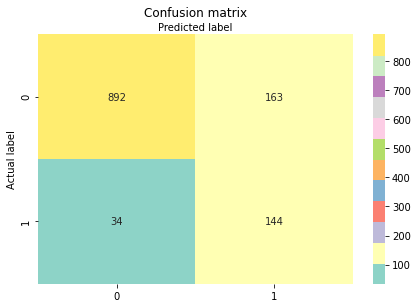

In [42]:
confusion_metric(valid["revenue"].values,model3.predict(valid)>0.5)

# Standardize Data

In [0]:
continuous_features = ['Administrative', 'AdminDuration', 'Informational', 'InforDuration',
       'ProductRelated', 'ProductDuration', 'BounceRates', 'ExitRates',
       'PageValues', 'SpecialDay']
categorical_features = ['Month', 'OperatingSystems', 'Browser','Region', 'TrafficType', 'VisitorType', 'Weekend']


In [0]:
for col in categorical_features:
    dummies = pd.get_dummies(shoppers[col], prefix=col)
    shoppers = pd.concat([shoppers, dummies], axis=1)
    shoppers.drop(col, axis=1, inplace=True)
shoppers = shoppers.drop(columns = {'revenue'})


In [46]:
shoppers.shape

(12330, 75)

In [0]:
# Training set: 80%
Train = shoppers[0:int(0.80*shoppers.shape[0])]
# Validation set: 10%
Valid = shoppers[int(0.80*shoppers.shape[0]):int(0.90*shoppers.shape[0])]
# Testing set: 10%
Test = shoppers[int(0.90*shoppers.shape[0]):]


In [47]:
features = Train.columns
features

Index(['Administrative', 'AdminDuration', 'Informational', 'InforDuration',
       'ProductRelated', 'ProductDuration', 'BounceRates', 'ExitRates',
       'PageValues', 'SpecialDay', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'OperatingSystems_8',
       'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10',
       'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3',
       'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
       'TrafficType_8', 'TrafficType_9',

# **KNeighborsClassifier**

####KNeighborsClassifier 

---



In [48]:
# Cross Validation find the optimal K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler 

scaler=StandardScaler()
scaler.fit(Train[features])

train_s = scaler.transform(Train[features])
valid_s =scaler.transform(Valid[features])
test_s =scaler.transform(Test[features])

for i in range(10):
  model= KNeighborsClassifier(n_neighbors=i+1,weights ="uniform")
  model.fit(train_s[::],train['revenue'])
  prediction= model.predict(valid_s[::])
  print(i+1, metrics.accuracy_score(valid['revenue'],prediction))


  

1 0.8280616382806164
2 0.8710462287104623
3 0.862124898621249
4 0.8653690186536902
5 0.8596918085969181
6 0.8653690186536902
7 0.862124898621249
8 0.8653690186536902
9 0.8686131386861314
10 0.8653690186536902


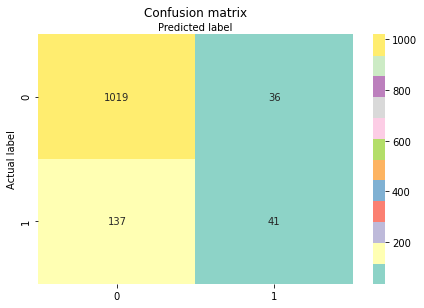

In [49]:
# pick n_neighbors = 7
model4= KNeighborsClassifier(n_neighbors=5,weights ="uniform")
model4.fit(train_s[::],train['revenue'])
prediction= model4.predict(valid_s[::])

confusion_metric(valid["revenue"].values, prediction)

####KNN Undersampling

---



In [50]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=False, ratio='majority')
Train_tl, Train_tl_y = tl.fit_sample(train_s, train['revenue'].values)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [51]:
for i in range(10):
  model= KNeighborsClassifier(n_neighbors=i+1,weights ="uniform")
  model.fit(Train_tl[::],Train_tl_y[::])
  prediction= model.predict(valid_s[::])
  print(i+1, metrics.accuracy_score(valid['revenue'],prediction))


1 0.7907542579075426
2 0.8588807785888077
3 0.8475263584752636
4 0.8580697485806975
5 0.8491484184914841
6 0.8605028386050284
7 0.8580697485806975
8 0.8669910786699108
9 0.8661800486618005
10 0.8669910786699108


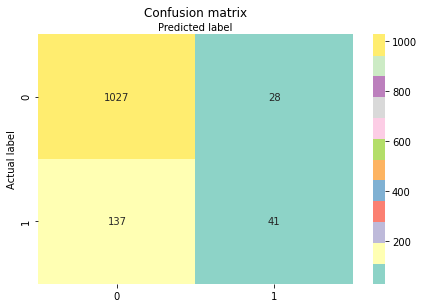

In [52]:
# pick n_neighbors = 9
model5= KNeighborsClassifier(n_neighbors=9,weights ="uniform")
model5.fit(Train_tl[::],Train_tl_y[::])
prediction= model5.predict(valid_s[::])

confusion_metric(valid["revenue"].values, prediction)

####KNN Oversampling

---

In [53]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
Train_sm, Train_sm_y = smote.fit_sample(train_s, train['revenue'].values)


for i in range(10):
  model= KNeighborsClassifier(n_neighbors=i+1,weights ="uniform")
  model.fit(Train_sm[::],Train_sm_y[::])
  prediction= model.predict(valid_s[::])
  print(i+1, metrics.accuracy_score(valid['revenue'],prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1 0.8118410381184104
2 0.8215733982157339
3 0.7510137875101379
4 0.7793998377939984
5 0.7169505271695052
6 0.7469586374695864
7 0.7072181670721817
8 0.7291159772911597
9 0.6877534468775345
10 0.716139497161395


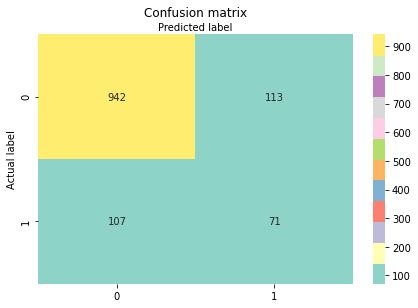

In [54]:
# pick n_neighbors = 2
model6= KNeighborsClassifier(n_neighbors=2,weights ="uniform")
model6.fit(Train_sm[::],Train_sm_y[::])
prediction= model6.predict(valid_s[::])

confusion_metric(valid["revenue"].values, prediction)

####KNN SMOTETomek

---

In [56]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
Train_smt, Train_smt_y = smt.fit_sample(train_s, train['revenue'].values)

for i in range(10):
  model= KNeighborsClassifier(n_neighbors=i+1,weights ="uniform")
  model.fit(Train_smt[::],Train_smt_y[::])
  prediction= model.predict(valid_s[::])
  print(i+1, metrics.accuracy_score(valid['revenue'],prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1 0.8037307380373074
2 0.8223844282238443
3 0.7445255474452555
4 0.7721005677210057
5 0.7023519870235199
6 0.7388483373884833
7 0.6991078669910786
8 0.7331711273317113
9 0.6974858069748581
10 0.7185725871857259


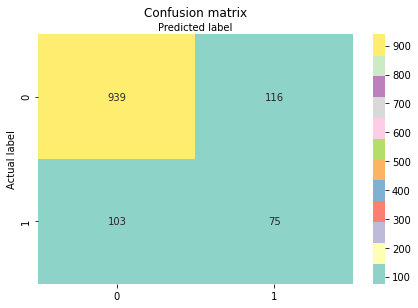

In [57]:
# pick n_neighbors = 2
model7= KNeighborsClassifier(n_neighbors=2,weights ="uniform")
model7.fit(Train_smt[::],Train_smt_y[::])
prediction= model7.predict(valid_s[::])

confusion_metric(valid["revenue"].values, prediction)

# **Random Forest**

####Random Forest

---

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler 


for i in range(10):
  model= RandomForestClassifier(max_depth=5,n_estimators=2000,bootstrap=False,max_features=i+1)
  model.fit(train_s[::],train['revenue'])
  prediction= model.predict(valid_s[::])
  print(i+1, metrics.accuracy_score(valid['revenue'],prediction))


1 0.8353609083536091
2 0.8353609083536091
3 0.8353609083536091
4 0.8353609083536091
5 0.8353609083536091
6 0.8353609083536091
7 0.8353609083536091
8 0.8475263584752636
9 0.8532035685320357
10 0.8678021086780211


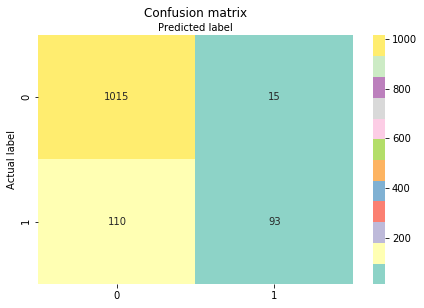

In [0]:
# pick n_neighbors = 10
model8= RandomForestClassifier(max_depth=5,n_estimators=2000,bootstrap=False,max_features=15)
model8.fit(train_s[::],train['revenue'])

prediction= model8.predict(valid_s[::])

confusion_metric(valid["revenue"].values, prediction)

####Random Forest Undersampling

---

In [0]:
for i in range(10):
  model= RandomForestClassifier(max_depth=5,n_estimators=2000,bootstrap=False,max_features=i+1)
  model.fit(Train_tl[::],Train_tl_y[::])
  prediction= model.predict(valid_s[::])
  print(i+1, metrics.accuracy_score(valid['revenue'],prediction))

1 0.8353609083536091
2 0.8353609083536091
3 0.8353609083536091
4 0.8353609083536091
5 0.8353609083536091
6 0.8353609083536091
7 0.8394160583941606
8 0.8491484184914841
9 0.8661800486618005
10 0.8718572587185726


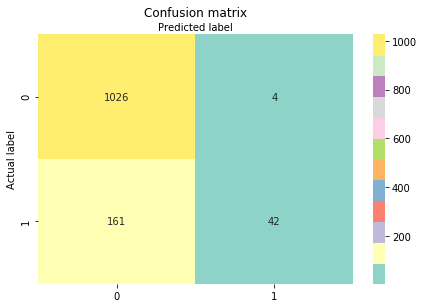

In [0]:
# pick n_neighbors = 10
model9= RandomForestClassifier(max_depth=5,n_estimators=2000,bootstrap=False,max_features=10)
model9.fit(train_s[::],train['revenue'])

prediction= model9.predict(valid_s[::])

confusion_metric(valid["revenue"].values, prediction)

####Random Forest Oversampling

---

In [0]:
for i in range(10):
  model= RandomForestClassifier(max_depth=5,n_estimators=2000,bootstrap=False,max_features=i+1)
  model.fit(Train_sm[::],Train_sm_y[::])
  prediction= model.predict(valid_s[::])
  print(i+1, metrics.accuracy_score(valid['revenue'],prediction))

1 0.7558799675587997
2 0.7931873479318735
3 0.8021086780210868
4 0.8313057583130575
5 0.845904298459043
6 0.8499594484995945
7 0.8596918085969181
8 0.8661800486618005
9 0.8686131386861314
10 0.8751013787510138


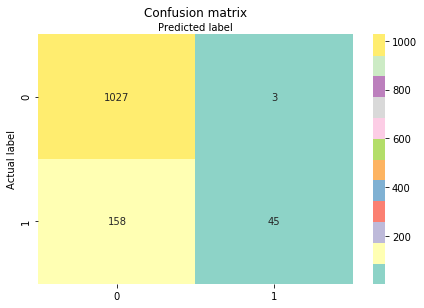

In [0]:
# pick n_neighbors = 10
model10= RandomForestClassifier(max_depth=5,n_estimators=2000,bootstrap=False,max_features=10)
model10.fit(train_s[::],train['revenue'])

prediction= model10.predict(valid_s[::])

confusion_metric(valid["revenue"].values, prediction)

####Random Forest SMOTETomek
 
---

In [0]:
for i in range(10):
  model= RandomForestClassifier(max_depth=5,n_estimators=2000,bootstrap=False,max_features=i+1)
  model.fit(Train_smt[::],Train_smt_y[::])
  prediction= model.predict(valid_s[::])
  print(i+1, metrics.accuracy_score(valid['revenue'],prediction))

1 0.754257907542579
2 0.7761557177615572
3 0.813463098134631
4 0.8304947283049473
5 0.8442822384428224
6 0.8523925385239254
7 0.8596918085969181
8 0.862124898621249
9 0.8718572587185726
10 0.8734793187347932


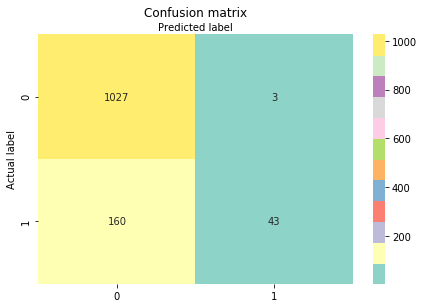

In [0]:
# pick n_neighbors = 10
model11= RandomForestClassifier(max_depth=5,n_estimators=2000,bootstrap=False,max_features=10)
model11.fit(train_s[::],train['revenue'])

prediction= model11.predict(valid_s[::])

confusion_metric(valid["revenue"].values, prediction)